In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [5]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [21]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

10



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[

Shape of DataFrame:  (27680, 8)


In [17]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [19]:
DRLAgent.train_model(model, episodes=5)


  0%|          | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 693076.1875
Final accumulative portfolio value: 6.930761875
Maximum DrawDown: -0.2812264055464706
Sharpe ratio: 1.2105686617848956


 20%|██        | 1/5 [00:10<00:42, 10.53s/it]

Initial portfolio value:100000
Final portfolio value: 688133.5625
Final accumulative portfolio value: 6.881335625
Maximum DrawDown: -0.27369721802679103
Sharpe ratio: 1.3071658940505062


 40%|████      | 2/5 [00:21<00:31, 10.58s/it]

Initial portfolio value:100000
Final portfolio value: 711348.3125
Final accumulative portfolio value: 7.113483125
Maximum DrawDown: -0.31844547601898787
Sharpe ratio: 1.1474451278427422


 60%|██████    | 3/5 [00:30<00:20, 10.10s/it]

Initial portfolio value:100000
Final portfolio value: 720704.9375
Final accumulative portfolio value: 7.207049375
Maximum DrawDown: -0.2978332803018634
Sharpe ratio: 1.3055002672279368


 80%|████████  | 4/5 [00:40<00:10, 10.18s/it]

Initial portfolio value:100000
Final portfolio value: 779890.8125
Final accumulative portfolio value: 7.798908125
Maximum DrawDown: -0.2977342678522762
Sharpe ratio: 1.179618935166784


100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


In [20]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

Evaluation

In [22]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

EIIE_results = {
    "training": environment._asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_81722/3540741641.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EI

Initial portfolio value:100000
Final portfolio value: 111676.015625
Final accumulative portfolio value: 1.11676015625
Maximum DrawDown: -0.05685687594016697
Sharpe ratio: 1.2179949139267485
Initial portfolio value:100000
Final portfolio value: 108640.9296875
Final accumulative portfolio value: 1.086409296875
Maximum DrawDown: -0.14224913545366225
Sharpe ratio: 0.5999313649138417
Initial portfolio value:100000
Final portfolio value: 104333.9765625
Final accumulative portfolio value: 1.043339765625
Maximum DrawDown: -0.11766907187772013
Sharpe ratio: 0.597594925520505
Initial portfolio value:100000
Final portfolio value: 259608.046875
Final accumulative portfolio value: 2.59608046875
Maximum DrawDown: -0.34678784089557724
Sharpe ratio: 0.7827840774140123
Initial portfolio value:100000
Final portfolio value: 122309.2265625
Final accumulative portfolio value: 1.223092265625
Maximum DrawDown: -0.04819352283412459
Sharpe ratio: 2.2707068438002063
Initial portfolio value:100000
Final portfoli

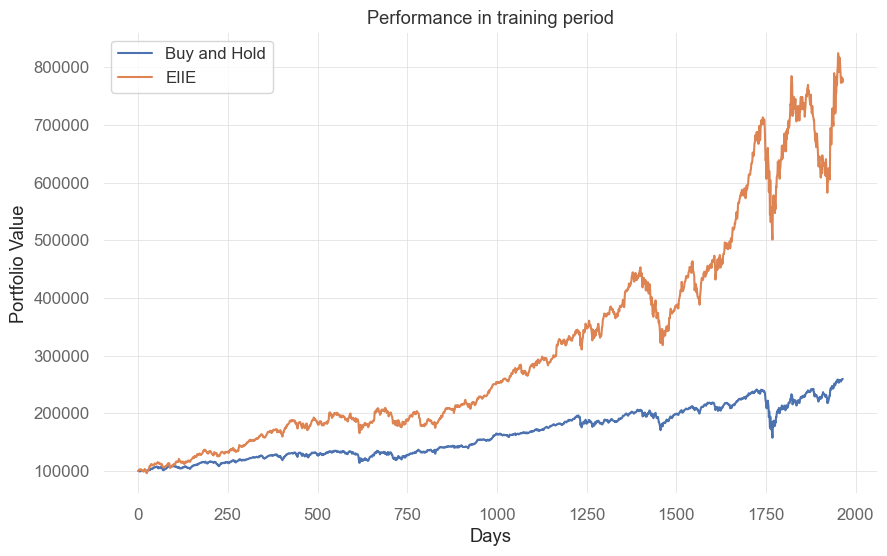

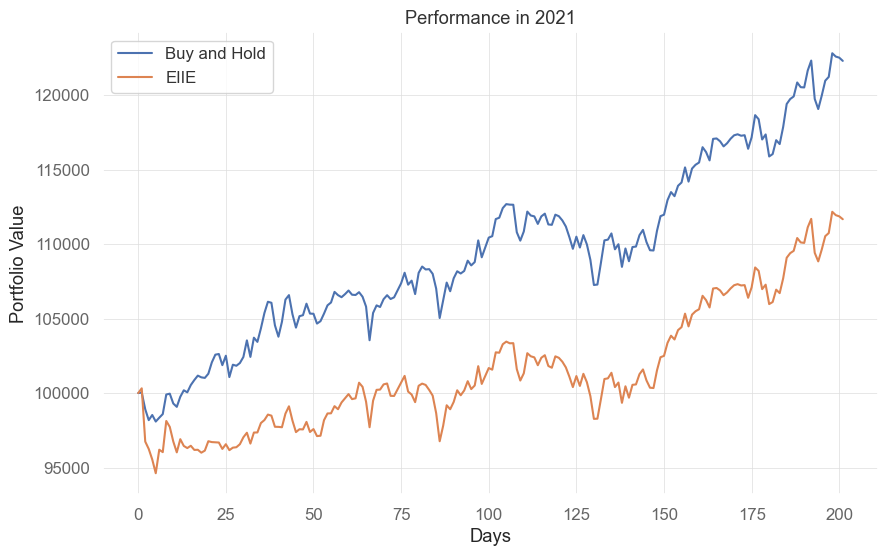

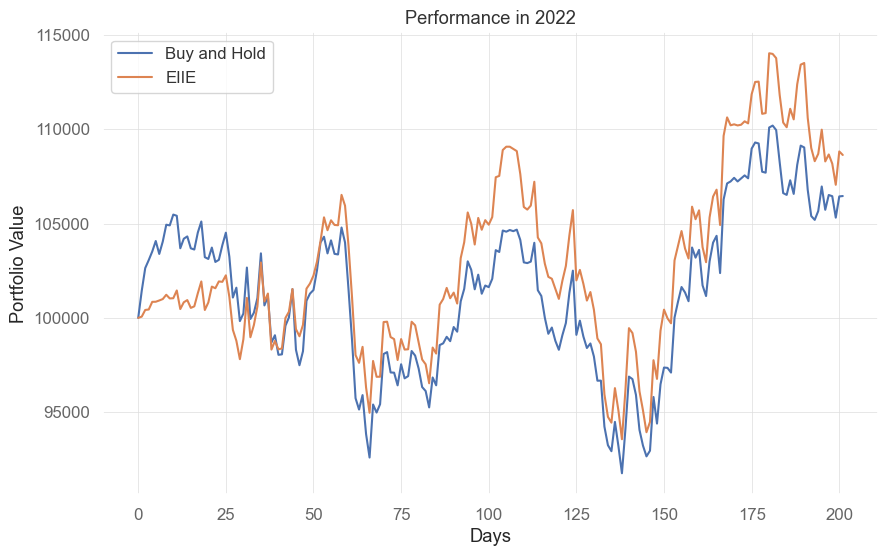

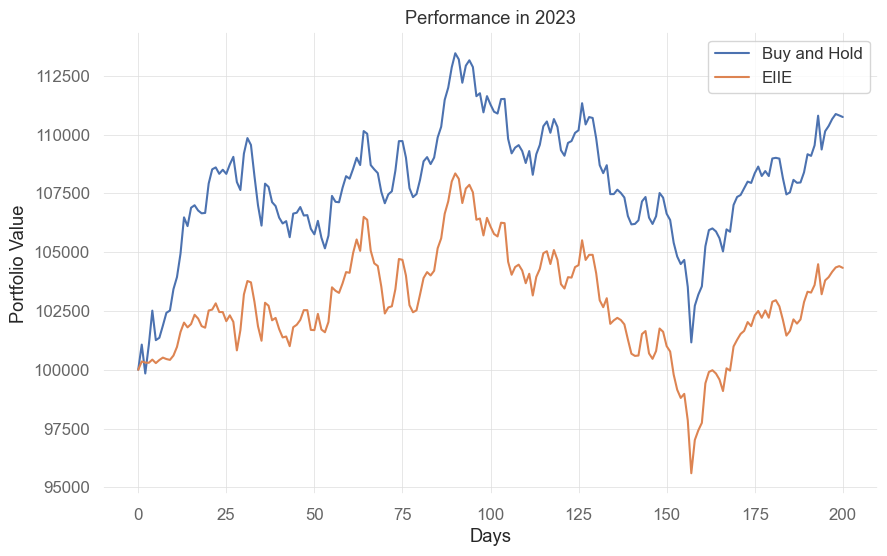

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()